In [19]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL, UMi, UMa, RMa
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber, QAMSource
from sionna.utils.metrics import compute_ber


In [20]:
import torch
carrier_frequency = 3.5e9
direction = "uplink"
#num_ut = 4
batch_size = 64
batch_size_fr_l = 12*batch_size*batch_size;
#CONFIG 
#Users and Receivers
NT = 4
NR = 8
sigma_size = NT;
#Modulation order
mod_n = 4
mod_n2 = 64

#SNR
SNR_db_min = 12.0
SNR_db_max = 17.0
SNR_db_max_two_mod = 30.0

#Flag and correlation coefficient for Kronecker channel model
corr_flag = True
batch_corr = True
rho = 0.6

temp= 0.5

#######################################################
###   Parameters of the Langevin algorithm ###
#######################################################
n_sigma_gaussian = 20
sigma_0 = 1
sigma_L = 0.004
n_sample_init = 70

n_traj = 30
step_size = 0.00003 #3e-5
M = 2
torch.cuda.empty_cache()
device = torch.device("cuda:0")
#device = torch.device("cpu")

H5_stack = []
H6_stack = []
H7_stack = []
H8_stack = []
H9_stack = []
H10_stack = []


In [21]:
import torch
def batch_matvec_mul(A, b):
        return torch.einsum(('ijk,ik->ij'), (A,b))

def QAM_N_const():
        n = mod_n
        constellation = np.linspace(int(-np.sqrt(n)+1), int(np.sqrt(n)-1), int(np.sqrt(n)))
        alpha = np.sqrt((constellation ** 2).mean())
        constellation /= (alpha * np.sqrt(2))
        constellation = torch.tensor(constellation).to(dtype=torch.float32)
        return constellation, float(alpha)

def modulate(indices):
        constel, _ = QAM_N_const()
        x = constel[indices]
        return x

def QAM_const():
        sqrt_mod_n = int(np.sqrt(mod_n))
        real_qam_consts = torch.empty((mod_n), dtype=torch.int64)
        imag_qam_consts = torch.empty((mod_n), dtype=torch.int64)
        for i in range(sqrt_mod_n):
            for j in range(sqrt_mod_n):
                index = sqrt_mod_n*i + j
                real_qam_consts[index] = i
                imag_qam_consts[index] = j

        return(modulate(real_qam_consts), modulate(imag_qam_consts))

In [22]:
class Unadjusted_langevin_algorithm():
    """
    ULA class to define the langevin algorithn plain (for each level)
    Input:
        generator: generator class, used to generate data
        n_samples: number of iterations to run the algorithm
        step: epsilon step size of the algorithm
    
    """
    def __init__(self,  n_samples, step, device):
        super(Unadjusted_langevin_algorithm, self).__init__()
        
        self.n_samples = n_samples
        self.step = step
        self.device = device

    
    def gaussian(self, zt,  sigma_annealed, NT, M):
        """
        Gaussian denoiser
        Input:
            generator: generator class, used to generate data
            sigma_annealed: variance of the noise annealed
            NT: number of users
            M: order of the constellation 
        Output:
            x_out: Estimation of the MMSE denoiser
        """

        #Calculate the distance of the estimated symbol to each true symbol from the constellation
        argr = torch.reshape(zt[:,0:NT],[-1,1]) - QAM_const()[0].to(device=self.device)
        argi = torch.reshape(zt[:,NT:],[-1,1]) - QAM_const()[1].to(device=self.device)

        #Reshape to handle batches
        argr = torch.reshape(argr, [-1, NT, M **2]) 
        argi = torch.reshape(argi, [-1, NT, M **2]) 

        #Softmax to calculate probabilites
        zt = torch.pow(argr,2) + torch.pow(argi,2)
        exp = -1.0 * (zt/(2.0 * sigma_annealed))
        exp = exp.softmax(dim=-1)
        #print(exp.shape)
        #rint(QAM_const()[0].shape)
        #Multiplication of the numerator with each symbol
        xr = torch.mul(torch.reshape(exp,[-1,M **2]).float(), QAM_const()[0].to(device=self.device))
        xi = torch.mul(torch.reshape(exp,[-1,M **2 ]).float(), QAM_const()[1].to(device=self.device))

        #Summation and concatenation to obtain the real version of the complex symbol
        xr = torch.reshape(xr, [-1, NT, M **2]).sum(dim=-1)
        xi = torch.reshape(xi, [-1, NT, M **2]).sum(dim=-1)
        x_out = torch.cat((xr, xi), dim=-1)

        return x_out


    def forward(self, Z0, singulars, Sigma, Uh, Vh, y, noise_sigma, sigma_gaussian, sigma_L, batch_size_fr_l, NT, M, Temp):
        """
        Forward pass
        Input:
            Z0: initial value
            singulars: vector with singular values
            Sigma: Matrix with the singular values
            y: observations
            Uh, Vh: left and right singular vectors
            noise_sigma: sqrt of the variance of the measuremnt noise
            sigma_gaussian:sqrt of the variance of the annealed noise at the level
            sigma_L: sqrt of the variance of the annealed noise at the last level 
            batch_size_fr_l: number of channel samples
            NT: Number of users
            M: order of the modulation
            Temp: Temperature parameter
        Output:
            Zi: estimation after the n_samples iterations
            samples: all the samples in the level
        """
        Zi = Z0
        samples = []
        singulars = singulars.to(device=self.device)

        yT = batch_matvec_mul(Uh, y.float())
        ZT = batch_matvec_mul(Vh, Zi)
        A = torch.zeros((batch_size_fr_l, 2 * NT)).to(device=self.device)

        #This step is to define which index value corresponds to noise_sigma > or < singualr * sigma_annealed
        index = noise_sigma.to(device=self.device) * torch.ones((batch_size_fr_l,2 * NT)).to(device=self.device) < singulars.to(device=self.device) * sigma_gaussian

        #Position dependent step size
        A[index == True] = sigma_gaussian**2 - noise_sigma**2/singulars[index == True]**2 
        A[index == False] = sigma_gaussian**2 * (1 - singulars[index == False]**2 * (sigma_gaussian**2/noise_sigma**2))
        
        for i in range(self.n_samples):

            grad = torch.zeros((batch_size_fr_l, 2 * NT)).to(device=self.device)

            #Score of the prior
            prior = (self.gaussian(Zi,  sigma_gaussian**2, NT, M) - Zi) / sigma_gaussian**2
            priorMul = batch_matvec_mul(Vh, prior)

            #Score of the likelihood
            diff =  (yT.float().to(device=self.device) - batch_matvec_mul(Sigma.float().to(device=self.device), ZT.float().to(device=self.device)))
            cov_diag = noise_sigma**2 * torch.ones( (batch_size_fr_l, 2 * NT)).to(device=self.device) - sigma_gaussian**2 * (singulars**2).float().to(device=self.device)
            cov_diag[index == True] = -1 * cov_diag[index == True]
            #print(type(cov_diag))
            #torch.add([cov_diag, 0.00001])
            cov_diag = cov_diag+ 0.00000001
            cov = torch.diag_embed(cov_diag, dim1=1, dim2=2)
            #print(cov.shape)
            #for i1 in range(batch_size_fr_l):
            #    for i2 in range(8):
            #        for i3 in range(8):
            #            if(cov[i1,i2,i3] == 0):
            #                 cov[i1,i2,i3] = 0.00001 
            cov_inv = torch.inverse(cov)
            aux = batch_matvec_mul(cov_inv, diff)
            grad_likelihood = batch_matvec_mul(torch.transpose(Sigma, 1, 2), aux)

            #Score of the posterior
            if torch.sum(index == False)!=0:
                grad[index == False] = grad_likelihood[index == False].to(device=self.device) +  priorMul[index == False].to(device=self.device)
            if torch.sum(index == True)!=0:
                grad[index == True] = grad_likelihood[index == True].to(device=self.device)

            #nosie defintiion
            noiseT = torch.randn(batch_size_fr_l, 2 * NT).to(device=self.device)

            ZT = ZT + (self.step / sigma_L**2) * torch.mul(A, grad.to(device=self.device)) + np.sqrt( (2 * Temp * self.step) / sigma_L**2) * torch.mul(torch.sqrt(A), noiseT)

            Zi = batch_matvec_mul(torch.transpose(Vh, 1, 2), ZT)                                                                                           

            #samples.append(Zi.cpu().detach().numpy())
        #print('OK')

        return Zi


In [23]:
import torch
class Langevin():
    """
    ULA class to define the langevin algorithn plain (for each level)
    Input:
        sigma_annealead_noise: vector with all the sqrt variances of the noise
        generator: generator class, used to generate data
        n_samples: number of iterations to run the algorithm
        step: epsilon step size of the algorithm
    
    """
    def __init__(self, sigma_annealead_noise,  n_samples, step, device):
        super(Langevin, self).__init__()
        self.num_noise_levels = sigma_annealead_noise.shape[0]
        self.n_samples = n_samples
        self.step = step
        self.device = device
        self.sigma_gaussian = sigma_annealead_noise
        self.Langevin_base = Unadjusted_langevin_algorithm( self.n_samples, self.step, self.device)

    def forward(self, singulars, Sigma, Uh, Vh, y, noise_sigma, NT, M, Temp):
        """
        Forward pass
        Input:
            singulars: vector with singular values
            Sigma: Matrix with the singular values
            y: observations
            Uh, Vh: left and right singular vectors
            noise_sigma: sqrt of the variance of the measuremnt noisea
            NT: Number of users
            M: order of the modulation
        Output:
            Zi: estimation after the n_samples iterations
            samples: all the samples in the level
        """
        
        r1 = 1
        r2 = -1
        bs = Sigma.shape[0]
        Z_init = ((r1 - r2) * torch.rand(bs, 2 * NT) + r2).to(device=self.device)
        sample_list = []

        for index in range(self.num_noise_levels):
            
            Zi = self.Langevin_base.forward(Z_init, singulars, Sigma, Uh, Vh, y, noise_sigma, self.sigma_gaussian[index], self.sigma_gaussian[-1], bs, NT, M, Temp)
            #sample_list.append(samples)

            #Define the initial value of the next level
            Z_init = torch.clone(Zi).to(device=self.device)
        return Zi
    

In [24]:
#sionna.config.xla_compat=True
#@tf.function(jit_compile=True)
def langevin_equalizer(device, H, y, noise_sigma):
    #sionna.config.xla_compat=True
    #initialization
    sigma_gaussian = np.exp(np.linspace(np.log(sigma_0), np.log(sigma_L), n_sigma_gaussian))
    #print(sigma_gaussian)

    #Create model
    langevin = Langevin(sigma_gaussian, n_sample_init, step_size, device)

    U,singulars,V = torch.svd(H)
    #for i in range(8):
    #    for j in range(batch_size_fr_l):
    #        for k in range(n_sigma_gaussian):
    #                if(noise_sigma**2 - singulars[j,i] **2 * sigma_gaussian[k]**2  == 0):
    #                    singulars[j,i] = singulars[j,i]+0.001
    
    
    
    Uh_real = torch.transpose(U.to(device=device), 1, 2).to(device=device)
    Vh_real = torch.transpose(V.to(device=device), 1, 2).to(device=device)
    
    #sigma_size = np.minimum(NT, NR)
    sigma_size = NT;
    Sigma = torch.zeros((batch_size_fr_l, 2 * sigma_size, 2 * sigma_size))
    for ii in range(batch_size_fr_l):
        Sigma[ii,:, :] = torch.diag(singulars[ii,:])

    #TRAJECTORY LOOP
    dist = torch.zeros((batch_size_fr_l,n_traj))
    list_traj = torch.zeros((batch_size_fr_l, 2*NT, n_traj))
    x_hat = torch.zeros((batch_size_fr_l, 2*NT))
    y = y.to(device=device)
    for jj in range(0, n_traj):
        #initialization
        #forward pass for one trajectory : it was sample_last,samples
        sample_last = langevin.forward(singulars.float(), Sigma.to(device=device).float(), 
                                    Uh_real.float(), Vh_real.float(), y, noise_sigma, 
                                    NT, M, temp)
        #print('Trajectory:')    
        #print(jj)
        #Generate n_traj realizations of Langevin and then choose the best one w.r.t to ||y-Hx||^2
        list_traj[:,:,jj] = torch.clone(sample_last)
        
        #print('list_traj: ')
        #print(list_traj[:,:,jj])
        dist[:, jj] = torch.norm(y.to(device=device) - batch_matvec_mul(H.to(device=device).float(),
                                                             sample_last.to(device=device)), 2, dim = 1)
        #print('dist: ')
        #print(dist[:,jj])
    # END OF LOOP
    idx = torch.argsort(dist, dim=1, descending = False)
    #print('whole list_traj: ')
    #print(list_traj.shape)
    #print(list_traj)
    for nn in range(0, batch_size_fr_l):
        x_hat[nn, :] = torch.clone(list_traj[nn,:,idx[nn,0]])
    #print('x_hat: ')
    #print(x_hat)
    return x_hat

#def torch.svd(H):
#    U, singulars, V = torch.linalg.svd(H)
#    return U,singulars,V
        

In [25]:
sionna.config.xla_compat=True

class Model(tf.keras.Model):
    """Simulate OFDM MIMO transmissions over a 3GPP 38.901 model.
    """
    def __init__(self, scenario, perfect_csi, wmethod):
        super().__init__()
        self._scenario = scenario
        self._perfect_csi = perfect_csi
        self.wmethod = wmethod

        # Internally set parameters
        self._carrier_frequency = 3.5e9
        self._fft_size = 64
        self._subcarrier_spacing = 30e3
        self._num_ofdm_symbols = 14
        self._cyclic_prefix_length = 10
        self._pilot_ofdm_symbol_indices = [2, 11]
        self._num_bs_ant = 8
        self._num_ut = 4
        self._num_ut_ant = 1
        self._num_bits_per_symbol = 2
        #self._coderate = 1

        # Create an RX-TX association matrix
        # rx_tx_association[i,j]=1 means that receiver i gets at least one stream
        # from transmitter j. Depending on the transmission direction (uplink or downlink),
        # the role of UT and BS can change.
        bs_ut_association = np.zeros([1, self._num_ut])
        bs_ut_association[0, :] = 1
        self._rx_tx_association = bs_ut_association
        self._num_tx = self._num_ut
        self._num_streams_per_tx = self._num_ut_ant


        # Setup an OFDM Resource Grid
        self._rg = ResourceGrid(num_ofdm_symbols=self._num_ofdm_symbols,
                                fft_size=self._fft_size,
                                subcarrier_spacing=self._subcarrier_spacing,
                                num_tx=self._num_tx,
                                num_streams_per_tx=self._num_streams_per_tx,
                                cyclic_prefix_length=self._cyclic_prefix_length,
                                pilot_pattern="kronecker",
                                pilot_ofdm_symbol_indices=self._pilot_ofdm_symbol_indices)

        # Setup StreamManagement
        self._sm = StreamManagement(self._rx_tx_association, self._num_streams_per_tx)

        # Configure antenna arrays
        self._ut_array = AntennaArray(
                                 num_rows=1,
                                 num_cols=1,
                                 polarization="single",
                                 polarization_type="V",
                                 antenna_pattern="omni",
                                 carrier_frequency=self._carrier_frequency)

        self._bs_array = AntennaArray(num_rows=1,
                                      num_cols=int(self._num_bs_ant/2),
                                      polarization="dual",
                                      polarization_type="cross",
                                      antenna_pattern="38.901",
                                      carrier_frequency=self._carrier_frequency)

        # Configure the channel model
        if self._scenario == "umi":
            self._channel_model = UMi(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "uma":
            self._channel_model = UMa(carrier_frequency=self._carrier_frequency,
                                      o2i_model="low",
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)
        elif self._scenario == "rma":
            self._channel_model = RMa(carrier_frequency=self._carrier_frequency,
                                      ut_array=self._ut_array,
                                      bs_array=self._bs_array,
                                      direction="uplink",
                                      enable_pathloss=False,
                                      enable_shadow_fading=False)

        # Instantiate other building blocks
        self._binary_source = BinarySource()
        self._qam_source = QAMSource(self._num_bits_per_symbol)

        self._n = int(self._rg.num_data_symbols*self._num_bits_per_symbol) # Number of coded bits
        #self._k = int(self._n*self._coderate)                              # Number of information bits
        #self._encoder = LDPC5GEncoder(self._k, self._n)
        #self._decoder = LDPC5GDecoder(self._encoder)
        self._mapper = Mapper("qam", self._num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(self._rg)

        self._ofdm_channel = OFDMChannel(self._channel_model, self._rg, add_awgn=True,
                                         normalize_channel=True, return_channel=True)

        self._remove_nulled_subcarriers = RemoveNulledSubcarriers(self._rg)
        self._ls_est = LSChannelEstimator(self._rg, interpolation_type="nn")
        self._lmmse_equ = sionna.ofdm.MFEqualizer(self._rg, self._sm)
        self.device = device;
        
        # self._lang_equ = langevin_equalizer(self.device, self.H, self.y)
        self._demapper = Demapper("app", "qam", self._num_bits_per_symbol, hard_out = True)

    def new_topology(self, batch_size):
        """Set new topology"""
        topology = gen_topology(batch_size,
                                self._num_ut,
                                self._scenario,
                                min_ut_velocity=0.0,
                                max_ut_velocity=0.0)

        self._channel_model.set_topology(*topology)

    #tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        self.new_topology(batch_size)
        no = ebnodb2no(ebno_db, self._num_bits_per_symbol, coderate = 1.0, resource_grid = self._rg)
        b = self._binary_source([batch_size, self._num_tx, self._num_streams_per_tx, 12*128])
        #print(b)
        #c = self._encoder(b)
        x = self._mapper(b)
        
        x_rg = self._rg_mapper(x)
        
        y, h = self._ofdm_channel([x_rg, no])
        
        if self._perfect_csi:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0
        else:
            h_hat = self._remove_nulled_subcarriers(h)
            err_var = 0.0
            h_hat = h_hat.numpy()
            
            for i in range(batch_size):
                for j in range(14):
                    for l in range(batch_size):
                        mean_ = 0
                        sigma_ = 0.1
                        tnsr_shp = (8, 4)
                        rnd_real = np.random.normal(mean_, sigma_, tnsr_shp)
                        rnd_img = np.random.normal(mean_, sigma_, tnsr_shp)
                        rnd_tnsr = rnd_real + 1j*rnd_img;
                        h_hat[i,0,:,:,0,j,l] += rnd_tnsr
            
            h_hat = tf.convert_to_tensor(h_hat)
            
            

      
        x_hat1, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
        
       
        if(self.wmethod == "lmmse"):
            if(ebno_db == 152.0):
                plt.title('x_hat1')
                plt.xlabel('Real part')
                plt.ylabel('Imag part')
                
                plt.scatter(tf.math.real(x_hat1), tf.math.imag(x_hat1))
                plt.tight_layout()
            llr = self._demapper([x_hat1, no_eff])
            
            return b, llr
        
        
        h_hat = tf.squeeze(h_hat, 4)
        h_hat = tf.squeeze(h_hat, 1)
        y = tf.squeeze(y, 1)

        tf.executing_eagerly()
        tmp = h_hat.numpy()
        h_hat = torch.tensor(tmp)
        
        tmp1 = y.numpy()
        y = torch.tensor(tmp1)

        tmp2 = no.numpy()
        no = torch.tensor(tmp2)
        
        cnt = 0
        
        h_hat = h_hat.to(device = device)
        y = y.to(device = device)
        
        H_HAT = torch.empty(batch_size, 16,8, 12,batch_size) 
        Y = torch.empty(batch_size, 16, 12, batch_size)
        tnsrlsth = []
        tnsrlsty = []
        for j in range(batch_size):
            cnt=0
            for i in range(14):
                if(i==2 or i==11):
                    continue
                
                
                h_hat_ij = h_hat[:, :, :, i, j]
                
                real_part = torch.real(h_hat_ij)
                im_part = torch.imag(h_hat_ij)
                h_up = torch.cat([real_part, -im_part], 2)
                h_down = torch.cat([im_part, real_part], 2)

                h_hat_ij = torch.cat([h_up, h_down],1)
                H_HAT[:,:,:,cnt,j] = h_hat_ij
                
                y_ij = y[:,:,i,j]
                
                real_part = torch.real(y_ij)
                im_part = torch.imag(y_ij)

                y_ij = torch.cat([real_part, im_part],1)
                Y[:, :, cnt, j] = y_ij
               
                
                cnt = cnt+1;
       
        H_HAT_ADJ = torch.empty(12*batch_size*batch_size, 16, 8)
        Y_ADJ = torch.empty(12*batch_size*batch_size, 16)

        cnt=0
        for i in range(batch_size):
            for j in range(12):
                for k in range(batch_size):
                    H_HAT_ADJ[cnt,:,:] = H_HAT[i,:,:,j,k]
                    cnt = cnt+1
        cnt=0
        for i in range(batch_size):
            for j in range(12):
                for k in range(batch_size):
                    Y_ADJ[cnt,:] = Y[i,:,j,k]
                    cnt = cnt+1


        
        x_hat = langevin_equalizer(self.device, H_HAT_ADJ, Y_ADJ, no)
        
        x_hat = torch.complex(x_hat[:,:NT], x_hat[:,NT:])
        
        x_hat_adj = torch.empty( batch_size, NT, 12*batch_size, dtype=torch.complex64)
        x_hat = x_hat.numpy()
        x_hat_adj = x_hat_adj.numpy()
       
        for i in range(batch_size):
            for j in range(12*batch_size):
                x_hat_adj[i,:,j] = x_hat[i*12*batch_size+j,:]
                
        
        x_hat = torch.from_numpy(x_hat)
        x_hat_adj = torch.from_numpy(x_hat_adj)
        x_hat_adj = x_hat_adj.unsqueeze(2)
        
        x_hat_adj = x_hat_adj.numpy()
        
        x_hat_adj = tf.convert_to_tensor(x_hat_adj)
        if(ebno_db == 20.0):
            #print(no)
            plt.title('x_hat_adj')
            plt.xlabel('Real part')
            plt.ylabel('Imag part')
            plt.scatter(tf.math.real(x_hat_adj), tf.math.imag(x_hat_adj))
            plt.tight_layout()
            
        
        llr = self._demapper([x_hat_adj, sigma_L])

        return b, llr

In [26]:
SIMS = {
    "ebno_db" : list(np.arange(0,10,1.0)),
    "scenario" : [ "umi"],
    "perfect_csi" : [True],
    "wmethod" : [  "lmmse"], #"langevin"
    "ber" : [],
    "bler" : [],
    "duration" : None
}

start = time.time()

for scenario in SIMS["scenario"]:
    for perfect_csi in SIMS["perfect_csi"]:
        for wm in SIMS["wmethod"]:

            model = Model(scenario=scenario,
                      perfect_csi=perfect_csi, wmethod = wm)
            if(wm == "langevin"):
                ber, bler = sim_ber(model,
                            SIMS["ebno_db"],
                            batch_size=64,
                            max_mc_iter=25,
                            num_target_block_errors=1000)
            else:
                ber, bler = sim_ber(model,
                            SIMS["ebno_db"],
                            batch_size=64,
                            max_mc_iter=50,
                            num_target_block_errors=1000)

            

            SIMS["ber"].append(list(ber.numpy()))
            SIMS["bler"].append(list(bler.numpy()))

SIMS["duration"] = time.time() -  start

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------


      0.0 | 8.2281e-02 | 9.9902e-01 |      129417 |     1572864 |         1023 |        1024 |         2.6 |reached target block errors
      1.0 | 7.7153e-02 | 9.9707e-01 |      121351 |     1572864 |         1021 |        1024 |         2.7 |reached target block errors
      2.0 | 7.2315e-02 | 9.9512e-01 |      113742 |     1572864 |         1019 |        1024 |         2.6 |reached target block errors
      3.0 | 7.3316e-02 | 9.8633e-01 |      115316 |     1572864 |         1010 |        1024 |         2.6 |reached target block errors
      4.0 | 7.2734e-02 | 9.8730e-01 |      114400 |     1572864 |         1011 |        1024 |         2.6 |reached target block errors
      5.0 | 7.0108e-02 | 9.6875e-01 |      137837 |     1966080 |         1240 |        1280 |         3.3 |reached target block errors
      6.0 | 7.0517e-02 | 9.6719e-01 |      138643 |     1966080 |         1238 |        1280 |         3.7 |reached target block errors
      7.0 | 6.7788e-02 | 9.6641e-01 |      13327

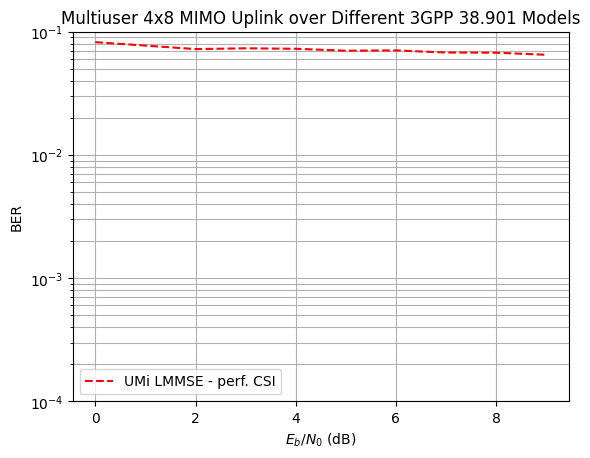

In [27]:
plt.figure()
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BER")
plt.grid(which="both")
#SIMS["scenario"] = ["uma", "rma"]
i=0
legend = []
for scenario in SIMS["scenario"]:
    for wm in SIMS["wmethod"]:
        if scenario=="umi":
            r = "r"
            t = "UMi"
        elif scenario=="uma":
            r = "b"
            t = "UMa"
        else:
            r = "g"
            t = "RMa"
        if wm == "langevin":
            r += "-"
            t += " Langevin"
        else:
            r += "--"
            t += " LMMSE"

        plt.semilogy(SIMS["ebno_db"], SIMS["ber"][i], r);
        s = "{} - {} CSI".format(t,"perf.")

        legend.append(s)
        i += 1
plt.legend(legend)
plt.ylim([1e-4, 1e-1])
plt.title("Multiuser 4x8 MIMO Uplink over Different 3GPP 38.901 Models");